# Cost Prediction for Logistic Company

### Table of Contents:
- __1.__ Introduction
- __2.__ Loading the dataset and deleting column "trip"
- __3.__ Exploring our target variable
- __4.__ Variable types, identifying numerical and categorical variables
- __5.__ Identifying missing values
- __6.__ Relationship between missing data and Cost
- __7.__ Exploring Time variable
- __8.__ Exporing Discrete variables
- __9.__ Exploring Continuous variables
- __10.__ Split dataset into train and test subsets
- __11.__ Numerical and categorical variables in subsets
- __12.__ Defining custom classes and constants
- __13.__ Use of Pipelines and Heatmap
- __14.__ Feature Selection
- __15.__ Modeling
- __15.1__ Linear Regressor
- __15.2__ Random Forest Regressor
- __15.3__ Multiple Models
- __15.4__ ElasticNet
- __16.__ Tensorflow
- __17.__ Best Model: RandomForestRegressor and parameter tuning
- __18.__ Predict New Test Data

### 1. Introduction

**Project Goal**

The project's goal is to predict trip costs for deliveries by developing a machine learning model capable of predicting these trip costs based on various explanatory variables that describe different aspects of deliveries. This is a regression problem.

**Importance:**

The significance of predicting trip costs lies in its potential to optimize the delivery network, save costs and/or forecast the company's expenses related to deliveries.

**Objective of the Machine Learning Model:**

Our goal is to minimize the disparity between the actual cost and the cost estimated by our model. The performance of the model will be assessed using the following metrics:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-squared (R2).

### 2. Loading the dataset and deleting column "trip"

Let's start __importing the required libraries__ for our analysis and __loading the provided dataset__.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for the yeo-johnson transformation
import scipy.stats as stats

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler


# to build the models and to select features
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import make_scorer, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, ElasticNet

#for parameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load dataset
data = pd.read_csv('train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(38999, 12)


,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777


In [3]:
# Checking the shape of the dataset: rows & columns
print(f'\033[94mNumber of records (rows) in the dataset are: {data.shape[0]}')
print(f'\033[94mNumber of features (columns) in the dataset are: {data.shape[1]}')

Number of records (rows) in the dataset are: 38999
Number of features (columns) in the dataset are: 12


Our provided dataset (for training) has __38'999 rows__ and __12 features__.

When visualizing the dataset we quickly realize that the feature __'trip'__ is just a unique ID for the delivery.

This won't add any value to our analysis or model. Let's __drop this column__.

In [4]:
# drop id, it is just a number given to identify each deliver
data.drop('trip', axis=1, inplace=True)

data.shape

(38999, 11)

### 3. Exploring our target variable

Now let's explore our __target variable cost__, to understand its distribution we will plot a histogram.

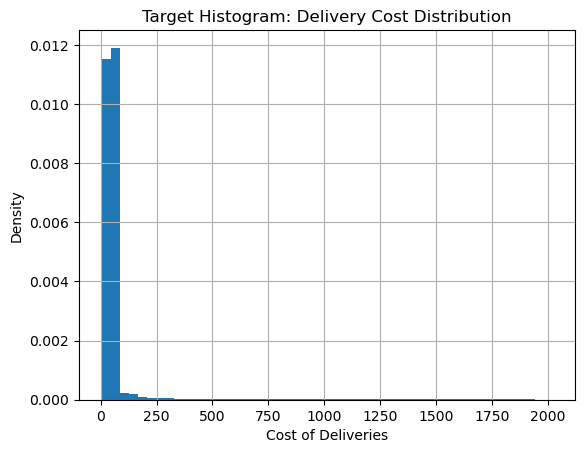

In [5]:
# histogran to evaluate target distribution

data['cost'].hist(bins=50, density=True)
plt.ylabel('Density')
plt.xlabel('Cost of Deliveries')
plt.title('Target Histogram: Delivery Cost Distribution')
plt.show()

__Observations:__
- Most of the values are at the far left of the histogram, with values lower than 250.
- We quickly identify some outliers with extreme costs up until 2000.
- Our target distribution is right-skewed.

Now, let's find some interesting statistics of our target.

In [6]:
# show mean, standard deviation, min and max values, quantiles
data['cost'].describe()

count    38999.000000
mean        80.972210
std        180.715055
min          5.000000
25%         38.768742
50%         46.468476
75%         70.239797
max       2019.734797
Name: cost, dtype: float64

__Observations:__
- Our max value (2019) is extremely high compared to our quantiles.
- This means, at least 75% of our target values are equal or lower than 70, while the other 25% of values can go as high as 2019.
- Some extreme outliers could be dragging our mean to 80.
- A high value for standard deviation (180) means we have data points far away from the mean.

Two values that will help us understand our target distribution are:
- __skewness:__ a measure of asymmetry
- __kurtosis:__ a measure of tailedness of the distribution

In [7]:
#skewness and kurtosis of Hours per Week
print("Skewness: %f" % data['cost'].skew())
print("Kurtosis: %f" % data['cost'].kurt())

Skewness: 6.969839
Kurtosis: 52.502269


__Observations:__
- Having a positive skewness indicates that our data is right-skewed, meaning most data points are located on the left end of our target distribution
- Having an extreme positive kurtosis means that our distribution presents a long right tail. This is visible when looking at the extreme outliers like deliveries costs around 2000.

We could also visualize our target distribution using a log function, as follows.

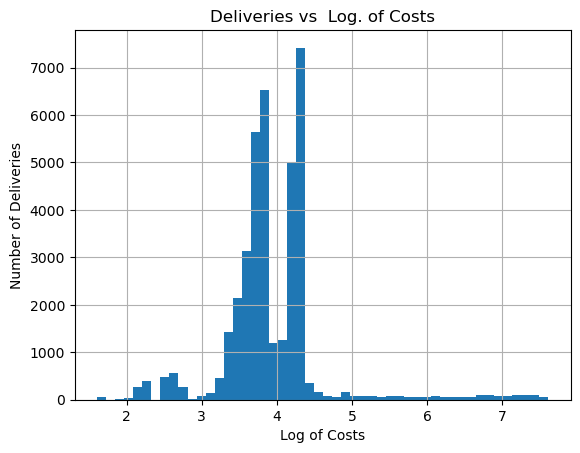

In [8]:
# let's transform the target using the logarithm
np.log(data['cost']).hist(bins=50, density=False)
plt.ylabel('Number of Deliveries')
plt.xlabel('Log of Costs')
plt.title('Deliveries vs  Log. of Costs')
plt.show()

### 4. Variable types, identifying numerical and categorical variables

Next, let's identify the categorical and numerical variables of our dataset.

In [9]:
data.dtypes

date                    object
dayPart                 object
exWeatherTag            object
originLocation          object
destinationLocation     object
distance                 int64
type                    object
weight                   int64
packageType             object
carrier                 object
cost                   float64
dtype: object

From the column names and our previous visualizations we have identified one 'date' column, which we need to __convert into datetime.__

In [10]:
#convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [11]:
# let's define a fucntion that identifies all numerical and categorical variables from a dataframe
def get_categorical_and_numerical_variables(dataframe, target, date_columns):
    cat_vars = [var for var in dataframe.columns if dataframe[var].dtype == 'O']
    num_vars = [var for var in dataframe.columns if var not in cat_vars and var != target and var not in date_columns]
    return cat_vars, num_vars

# get categorical and numerical variables from our dataset
cat_vars, num_vars = get_categorical_and_numerical_variables(data, 'cost', ['date'])

In [12]:
print(f"We have identified {len(cat_vars)} categorical variables:")
display(cat_vars)
print(f"We have identified {len(num_vars)} numerical variables:")
display(num_vars)

We have identified 7 categorical variables:


['dayPart',
 'exWeatherTag',
 'originLocation',
 'destinationLocation',
 'type',
 'packageType',
 'carrier']

We have identified 2 numerical variables:


['distance', 'weight']

__Let's go ahead and analyze the categorical variables present in the dataset.__

In [13]:
print('Number of categorical variables: ', len(cat_vars))
# let's visualize the values of the categorical variables
data[cat_vars].head()

Number of categorical variables:  7


,dayPart,exWeatherTag,originLocation,destinationLocation,type,packageType,carrier
0,night,NaN,S4,D7,expedited,NaN,D
1,night,NaN,S8,D1,NaN,NaN,B
2,night,NaN,S9,D5,NaN,NaN,B
3,day,NaN,S9,D7,NaN,NaN,C
4,day,snow,S9,D1,NaN,NaN,B


__Let's find the Number of labels: cardinality, of our categorical variables__

<Axes: title={'center': 'Number of Unique values per categorical column'}>

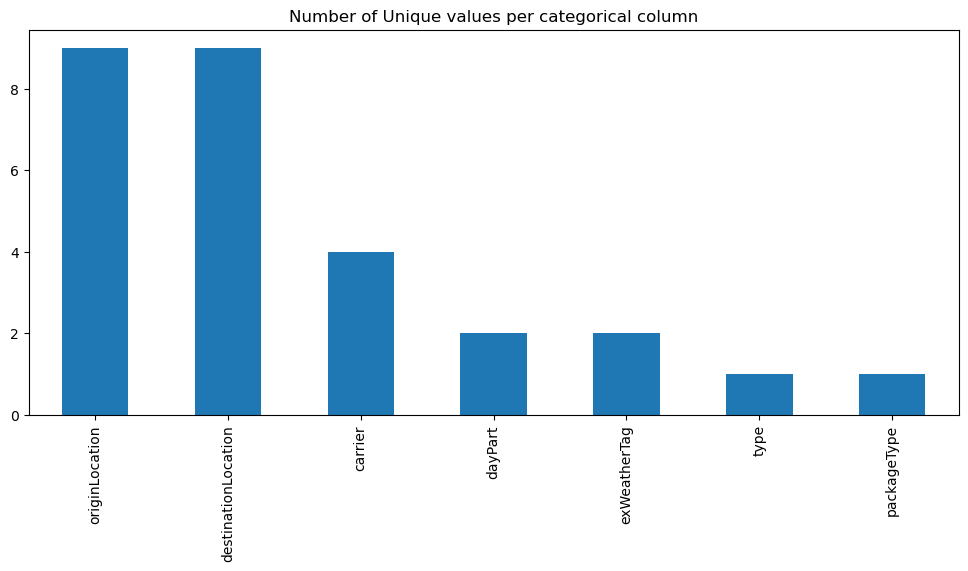

In [14]:
# We counted unique categories with pandas unique() 
# and then plot them in descending order

data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5), title="Number of Unique values per categorical column")

__Observations:__
- For all categorical variables we have reasonable number of unique values (not more than 9)
- Variables with most unique values are: origin and destination Location
- While variables with least unique values are: type and packageType

## 5. Identifying missing values

Let's go ahead and find out which variables of the dataset contain missing values.

In [15]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data
data[vars_with_na].isnull().mean().sort_values(ascending=False)

packageType     0.935896
type            0.903895
exWeatherTag    0.874817
dtype: float64

Our dataset contains a few variables with a big proportion of missing values (3 variables)

This means that to train a machine learning model with this data set, we need to impute the missing data in these variables.

We can also visualize the percentage of missing values in the variables as follows:

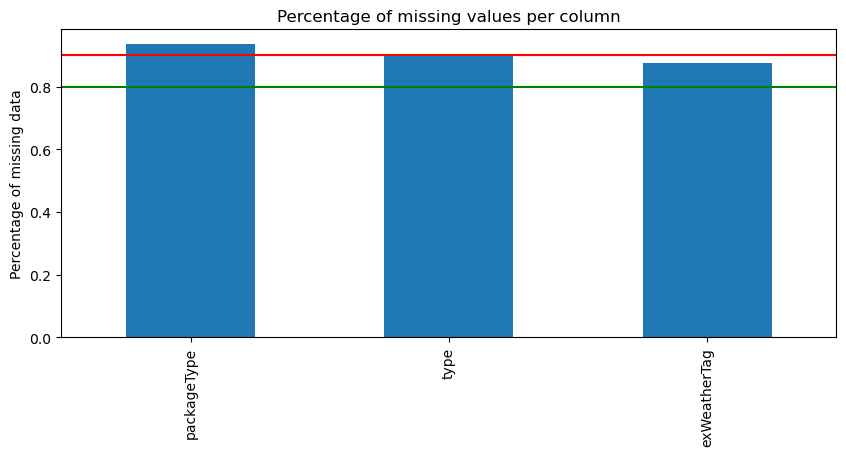

In [16]:
# Let's plot a barplot showing missing values a thresholds at 80% and 90% of the data
data[vars_with_na].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('Percentage of missing data')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axhline(y=0.80, color='g', linestyle='-')
plt.title("Percentage of missing values per column")

plt.show()

In [17]:
# now we can determine which variables, from those with missing data,
# are numerical and which are categorical

cat_na = [var for var in cat_vars if var in vars_with_na]
num_na = [var for var in num_vars if var in vars_with_na]

print('Number of categorical variables with missing values: ', len(cat_na))
print('Number of numerical variables with missing values: ', len(num_na))

Number of categorical variables with missing values:  3
Number of numerical variables with missing values:  0


In [18]:
print('The columns with missing values are:')
cat_na

The columns with missing values are:


['exWeatherTag', 'type', 'packageType']

### 6. Relationship between missing data and Cost

Let's assess the costs of delivery in those instances where information is absent. We will perform this analysis for each variable that exhibits missing data.

In [19]:
# Define a function that fills the null values with the label 'Null Group' so they can be
# grouped, visualized and worked on
def analyse_null_col(column):
    temp_fill = 'Null Group'
    data[column].fillna(temp_fill, inplace = True) # fill null values
    grouped_data_with_null = data.groupby(column)['cost'] # group values
    summary_stats = grouped_data_with_null.agg(['min', 'max', 'mean','std']) # get the summary stats
    print(summary_stats)
    print('-' *75)

In [20]:
for col in cat_na:
    analyse_null_col(col)

                   min          max       mean         std
exWeatherTag                                              
Null Group    5.000000  2019.734797  80.953913  180.504664
heat          7.153383  1992.365766  81.299811  188.594032
snow          5.000000  1833.835811  81.003063  179.036883
---------------------------------------------------------------------------
             min          max       mean         std
type                                                
Null Group   5.0  2019.734797  82.322571  189.975954
expedited   60.0   145.921616  68.271687   13.883375
---------------------------------------------------------------------------
                  min          max        mean         std
packageType                                               
Null Group    5.00000    85.664808   49.703993   18.042435
TT           58.83317  2019.734797  537.475675  531.157714
---------------------------------------------------------------------------


__Observations:__

In some variables, the average cost in the delivery for *exweatherTag* is similar when the data is not missing. On the other hand, for *packageType* and to a lesser extent *type*, the average differs. This data could contribute to improving the model's performance.

In [21]:
# Define a function to plot a grid of scatterplots using a dataframe and a column as hue
def visualize_null_col(column):
    plot = sns.pairplot(data, hue = column) # plot pair scatterplots
    plot.fig.suptitle(f"Visualization of Numerical Columns as per values of {column}", y=1.08) # y= some height>1

C:\Users\elsm5\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\elsm5\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\elsm5\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


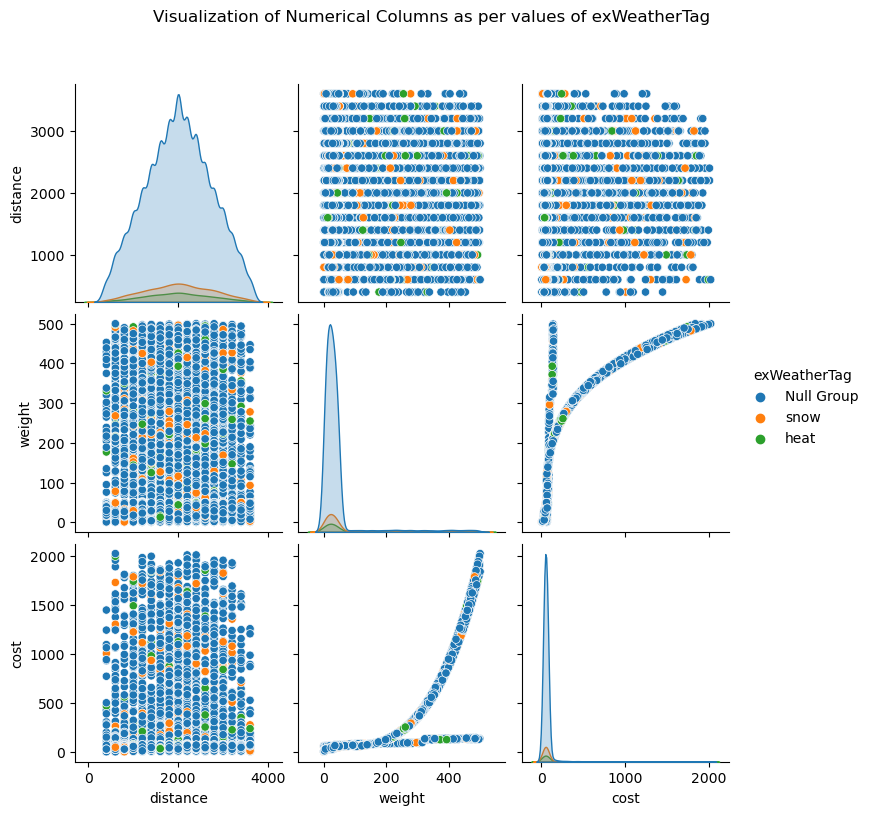

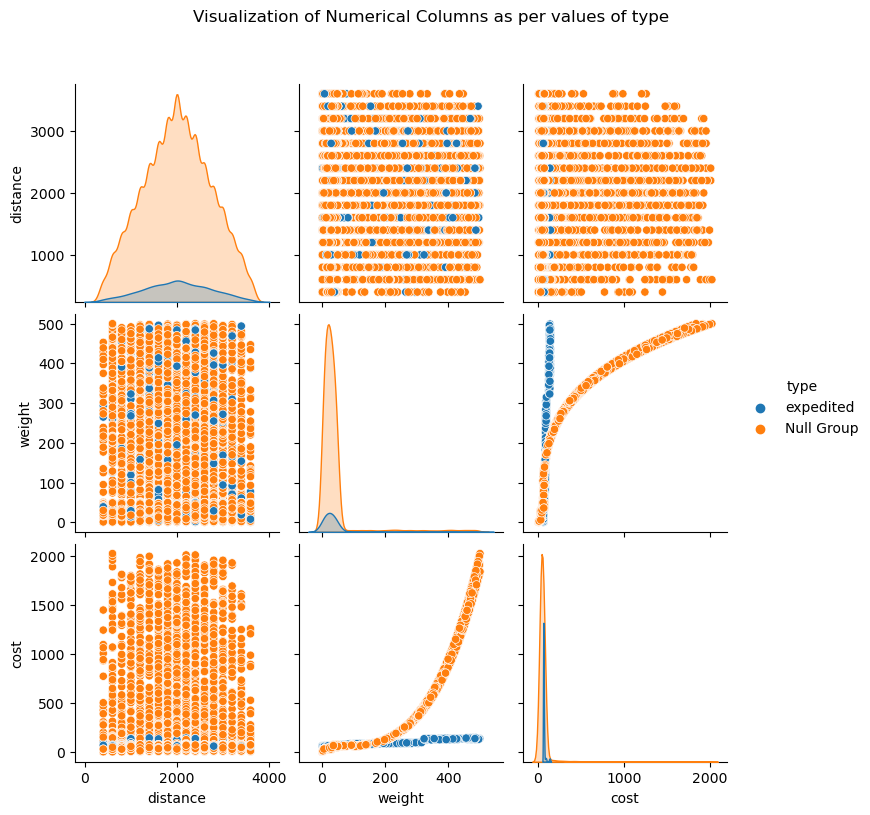

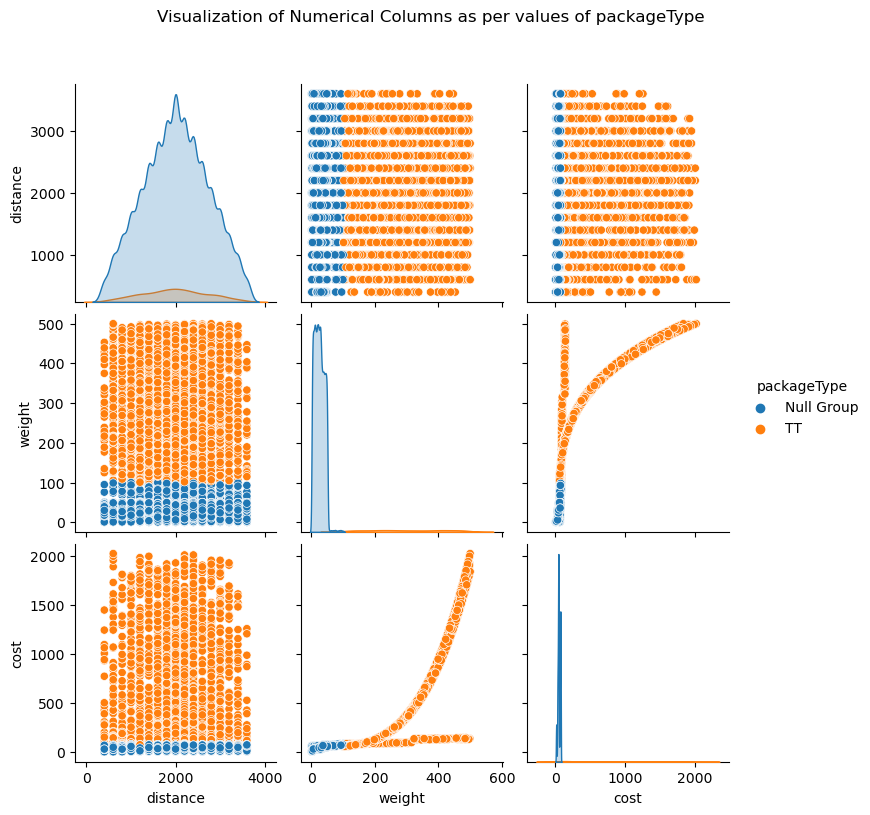

In [22]:
for col in cat_na:
    visualize_null_col(col)

__Observations 1st scatterplots grid (exWeatherTag):__
- We find a relationship between weight and cost, as we find a cuadratic relationship between the weight and cost of some deliveries.
- Another group of deliveries however, present a linear relationship between weight and cost.
- There are 2 clearly defined groups when plotting weight vs cost, however the values of exWeatherTag is not related at all to these groups.

__Observations 2nd scatterplots grid (type):__
- Relationships between weigth and cost are visualized once again. However, now we can clearly distinguish between type values.
- The __type__ column has 2 possible values: '__expedited__' and '__null__'.
- The __expedited__ values show a __linear relationship__ between their weight and cost of deliveries.
- The __null__ group values show a __quadratic relationship__ between their weights and cost of deliveries.

__Observations 3rd scatterplots grid (packageType):__
- For this __packageType__ column we have 2 possible values: '__TT__' and '__null__'. However, both groups are not showing any relationship to the trends between costs and weight.
- What we actually find are defined clusters of data points for both "__cost vs distance__" and "__weight vs distance__" scatterplots.
- The null group of packageType presents __lower costs and lower weights for any distance.__

__Now let's explore the relation between our target(cost) and weight for values of 'type' column (expedited, null-or-non-expedited)__

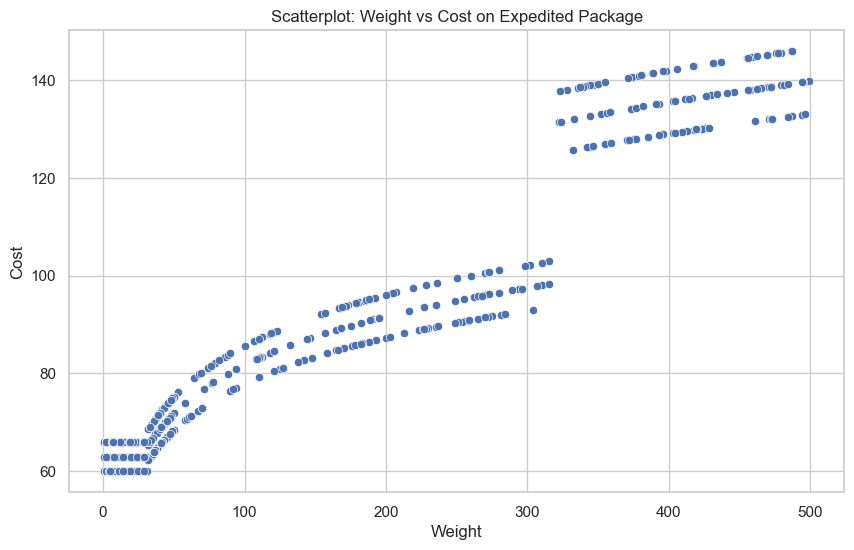

In [23]:
#visualizing cost vs weight for two different types
sns.set(style="whitegrid")
# Create a scatterplot for 'weight' vs 'cost' for expedited packages
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weight', y='cost', data=data[data['type']=='expedited'], marker='o')
plt.title('Scatterplot: Weight vs Cost on Expedited Package')
plt.xlabel('Weight')
plt.ylabel('Cost')
plt.show()


__Observations:__
- Remember we are only plotting data points with type __expedited__.
- Initially, the __relation between both Weight and cost is constant__, up until certain weight __threshold (around 40).__
- Afterwards, the __relation is defined by a log function, as in cost = log(weight)__. This means that the cost of the packages do not increment that much compared to weight, up until certain threshold.
- __After 300 weight units__, the cost is shifted by a constant, __increasing dramatically.__

__Now let's plot the same scatterplot but with Non-Expedited packages (previously null values of type).__

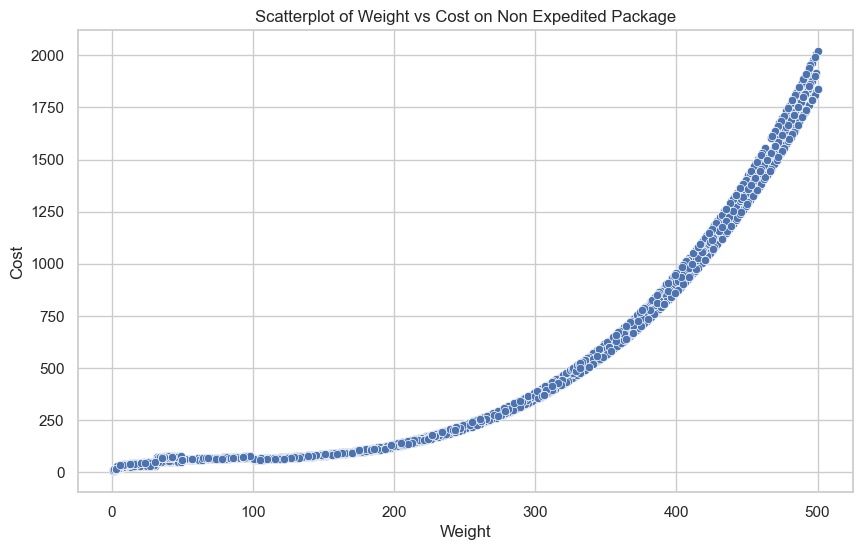

In [24]:
# visualizing cost vs weight for two different types
sns.set(style="whitegrid")
# Create a scatterplot for 'weight' vs 'cost' for non expedited packages
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weight', y='cost', data=data[data['type']!='expedited'], marker='o')
plt.title('Scatterplot of Weight vs Cost on Non Expedited Package')
plt.xlabel('Weight')
plt.ylabel('Cost')
plt.show()

__Observations:__
- The __relationship between weight and cost for non-expedited type of packages__ (previously null values of type) is clearly visible.
- The __exponential function can describe the relationship between both variables__, as in the cost of delivery dramatically increases for higher weight units.

__Now let's explore the packageType variable/column.__

For this packageType column we had 2 possible values: __'TT', and 'null'__.

Let's try to find some patterns behind their values.

In [25]:
# Find data points with less than 100 weight units and TT value as packageType
data[(data['weight'] < 100) & (data['packageType'] == 'TT')]

,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost


In [26]:
# Find the max value of weight for the TT group of data points (from packageType)
data[data['packageType'] != 'TT']['weight'].max()

100

It seems like 'TT' is only assigned to packages with less or equal to 100 weight units.

__These Visualizations helped us conclude the following:__

- __exWeatherTag:__ This feature has values for the weather type but no trends are seen for the difference in its value

- __type:__ There are two values for type and when the value for type is expedited, It seems there is a weight cap seemingly around 40, if the package is expeditedthe cost of the delivery doesnt change but when its not expedited,the cost of the delivery increases exponentially with weight

- __packageType:__ This feature has value TT which is only true when the weight of the package is more than 100. So it will not help the model much since we already have the weight feature alongside it.

## 7. Exploring Time variable
As we previously identified, we only have __1 variable denoting time__: 'date'.

This column give us the __specific date of the delivery.__

Let's plot some interesting graphics to find patterns between our __'date'__ variable and our target __'cost'.__

In [27]:
# Check our data types once again
data.dtypes

date                   datetime64[ns]
dayPart                        object
exWeatherTag                   object
originLocation                 object
destinationLocation            object
distance                        int64
type                           object
weight                          int64
packageType                    object
carrier                        object
cost                          float64
dtype: object

In [28]:
# Define a function to plot cost of deliveries vs a time variable
def plot_total_cost_by_time(total_cost_by_time, time_label, color):
    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
    plt.plot(total_cost_by_time.index.astype(str), total_cost_by_time.values, marker='o', color=color)
    plt.title('Total Cost of Delivery vs. '+time_label)
    plt.xlabel(time_label)
    plt.ylabel('Total Delivery Cost')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

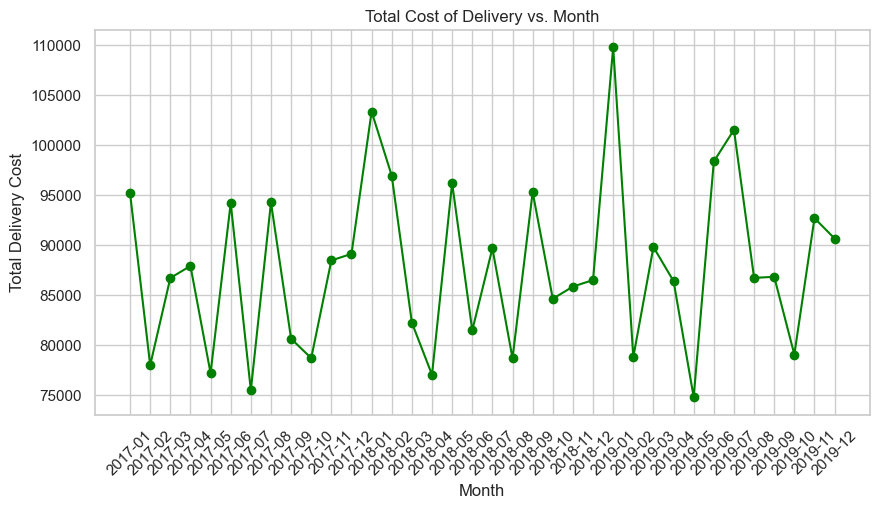

In [29]:
# Let's plot a line chart (suitable for time variables) to visualize the relationship between months and cost
total_cost_by_month = data.groupby(data['date'].dt.to_period("M"))['cost'].sum()
plot_total_cost_by_time(total_cost_by_month, 'Month', 'green')

__Observations:__
- We can not easily visualize a clear relationshp between months (sequential order) and cost of deliveries.
- __Cost of delivery peaks at December and/or January of every year.__
- It seems that __both variables are not correlated.__

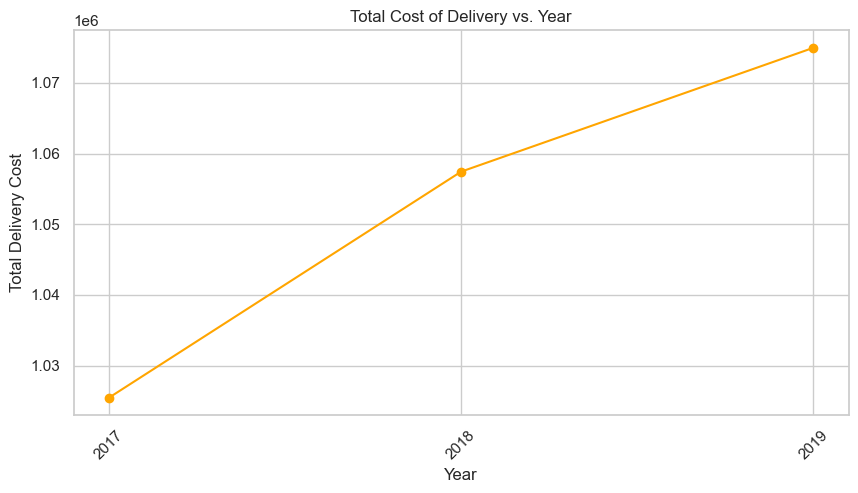

In [30]:
# Let's plot a line chart again (suitable for time variables) to visualize the relationship between years and cost
total_cost_by_year = data.groupby(data['date'].dt.year)['cost'].sum()
plot_total_cost_by_time(total_cost_by_year, 'Year', 'orange')

__Observations:__
- Theres is a somewhat __linear relationship between the year and total cost of deliveries in the year.__
- The relation between both variables are __positive.__

## 8. Exporing Discrete variables

Let's go ahead and find which variables are discrete, i.e., show a finite number of values

In [31]:
# Checking the unique values in each column
for col in data:
    print(f"\033[94mUnique values in '{col}' column:")
    print(data[col].unique(), end='\n\n')

Unique values in 'date' column:
<DatetimeArray>
['2017-09-06 00:00:00', '2017-10-21 00:00:00', '2017-07-15 00:00:00',
 '2017-10-22 00:00:00', '2019-12-11 00:00:00', '2017-06-19 00:00:00',
 '2017-02-09 00:00:00', '2018-10-01 00:00:00', '2018-11-26 00:00:00',
 '2019-05-26 00:00:00',
 ...
 '2018-02-02 00:00:00', '2019-07-07 00:00:00', '2019-11-02 00:00:00',
 '2017-08-23 00:00:00', '2017-04-15 00:00:00', '2017-03-08 00:00:00',
 '2018-06-22 00:00:00', '2019-08-25 00:00:00', '2019-04-09 00:00:00',
 '2019-10-04 00:00:00']
Length: 1074, dtype: datetime64[ns]

Unique values in 'dayPart' column:
['night' 'day']

Unique values in 'exWeatherTag' column:
['Null Group' 'snow' 'heat']

Unique values in 'originLocation' column:
['S4' 'S8' 'S9' 'S6' 'S7' 'S3' 'S5' 'S1' 'S2']

Unique values in 'destinationLocation' column:
['D7' 'D1' 'D5' 'D4' 'D2' 'D9' 'D6' 'D3' 'D8']

Unique values in 'distance' column:
[2200 1800 2800 3200 2000 1400 2400 1200 1600  600  800 2600 3400 3000
  400 1000 3600]

Unique val

In [32]:
#  let's make a list of discrete variables
discrete_vars = [var for var in num_vars if len(data[var].unique()) < 20]
print('Number of discrete variables: ', len(discrete_vars))
discrete_vars

Number of discrete variables:  1


['distance']

In [33]:
data[discrete_vars].head()

,distance
0,2200
1,1800
2,2800
3,3200
4,2000


We tried to find discrete variables by looking through columns that have __less than 20 possible values.__

Only 1 column meet these requirements: __'distance'__.

This discrete variable is the __distance traveled for delivery from originLocation to destinationLocation.__

Let's find the __relation between distance and cost of deliveries by plotting a scatterplot.__

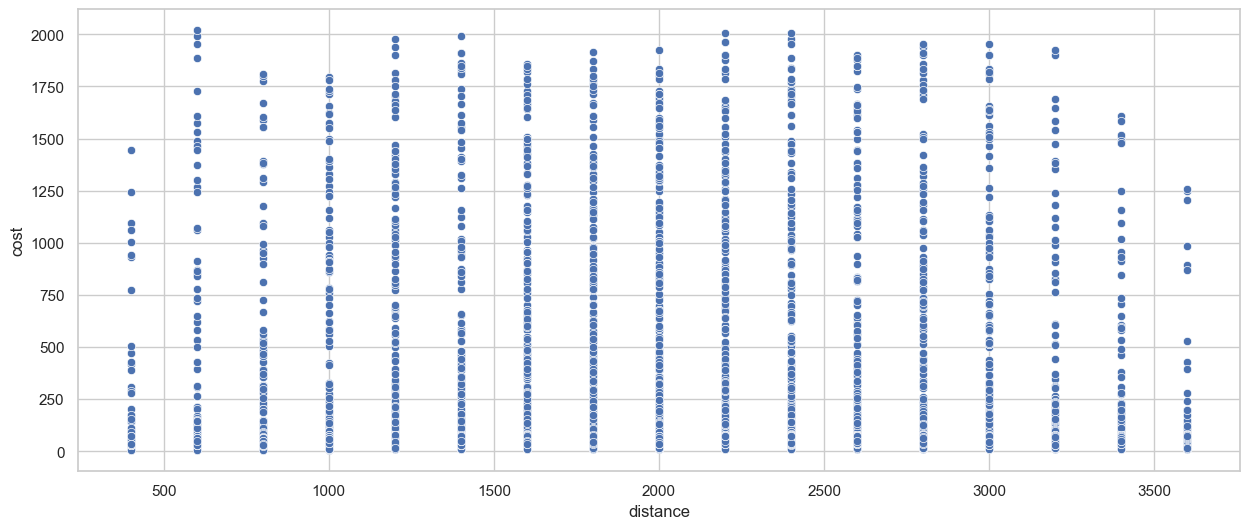

In [34]:
# Set a larger plot size
plt.figure(figsize=(15, 6))

for var in discrete_vars:
    sns.scatterplot(x= var, y= 'cost',data = data)

__Observations:__
- Surprisingly, there is __no clear relationship between both variables.__
- All possible distances present all ranges of costs starting from near __zero up until 2000.__
- It seems that distance is __not an influential variable over the cost__ of deliveries.

## 9. Exploring Continuous variables

Let's go ahead and find the distribution of the continuous variables.

We will consider continuous variables to all those that are not temporal or discrete.

In [35]:
# make list of continuous variables
cont_vars = [var for var in num_vars if var not in discrete_vars]
print('Number of continuous variables: ', len(cont_vars))
cont_vars

Number of continuous variables:  1


['weight']

In [36]:
data[cont_vars].head()

,weight
0,50
1,12
2,1
3,50
4,43


We are just left with __1 continuous variable: 'weight'__

To understand the __distribution of our continuous variable__ we will __plot a histogram__ using the hist method.

We can also calculate the __skeweness and kurtosis__ to learn more about the distribution and __variable behaviour.__

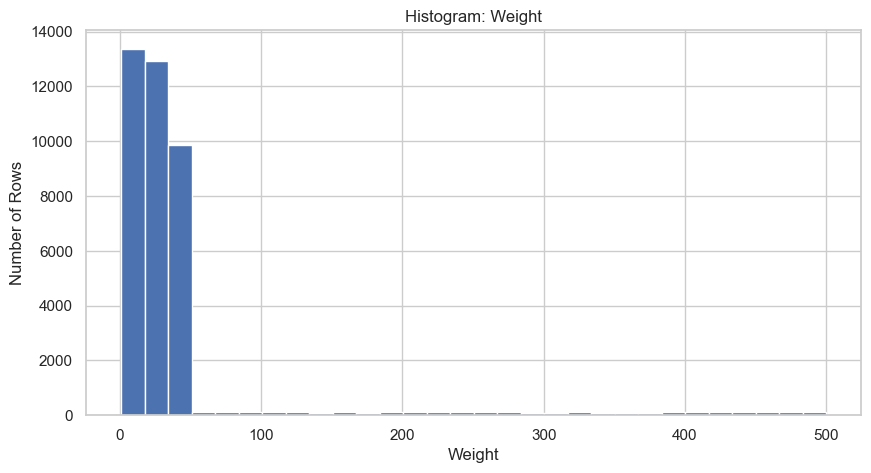

In [37]:
# lets plot histograms for all continuous variables
data[cont_vars].hist(bins=30, figsize=(10,5))
plt.title('Histogram: Weight')
plt.xlabel('Weight')
plt.ylabel('Number of Rows')
plt.show()

In [38]:
#skewness and kurtosis of Hours per Week
print("Skewness: %f" % data[cont_vars].skew())
print("Kurtosis: %f" % data[cont_vars].kurt())

Skewness: 4.153602
Kurtosis: 17.503858


__Observations:__
- The variable are __not normally distributed.__
- Our data is __right-skewed__, meaning most of the data is concentrated in the left side, with a long tail to the right.
- Sometimes, transforming the variables to improve the value spread, improves the model performance. But it is unlikely that a transformation will help change the distribution of the super skewed variable dramatically.
- There are some __outliers with weights exceeding 100 units.__

# Feature Engineering

## 10. Split dataset into train and test subsets


Before we can use any machine learning model, we have to __split our data into 2 subsets: training and testing.__

When we engineer features, some __techniques learn parameters from data.__

It is important to learn these parameters only from the train set, to __avoid over-fitting.__

In [39]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop([ 'cost'], axis=1), # predictive variables
    data['cost'],
    test_size=0.1,
    random_state=42,
)

X_train.shape, X_test.shape

((35099, 10), (3900, 10))

We are left with __35'099 rows for training__ and __3'900 rows for testing__.

We decided to __apply a log function on our target (in both train and test subsets).__

This will __help decreasing the distance between the data points and our model predictions.__

In [40]:
# let's apply a Numpy log function on our target test & train
y_train = np.log(y_train)
y_test = np.log(y_test)

### 11. Numerical and categorical variables in subsets

Let's go through our previously identified numerical and categorical variables again.

We already have the defined columns as follows.

We also identified columns with null values (3 columns) and the relationship between all of them (including missing values) and our target cost of deliveries.

In [41]:
print('Categorical Variables:',cat_vars)
print('Numerical Variables:',num_vars)
print('Categorical Variables With Null:',cat_na)

Categorical Variables: ['dayPart', 'exWeatherTag', 'originLocation', 'destinationLocation', 'type', 'packageType', 'carrier']
Numerical Variables: ['distance', 'weight']
Categorical Variables With Null: ['exWeatherTag', 'type', 'packageType']


__Categorical Variables:__

Let's __define these columns within our subsets: test and train.__

In [42]:
# define test and train categorical variables
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

len(cat_vars)

7

In [43]:
# print percentage of missing values per variable within our train subset
(X_train[cat_na]=='Null Group').mean().sort_values(ascending=False)

packageType     0.936124
type            0.903701
exWeatherTag    0.874612
dtype: float64

When we explored the categorical values with null value, we found that the weather didnt have much impact to the cost even thought if its null.Similarly for package type the data with null value had lower cost but was highly related to the Weight( If weight>100, packageType == TT), since we already have the weight feature, this feature is not significant to the model. On the other hand the column type had signifact impact on the cost so, only this column will be kept for further processing and the rest of the features will be removed. This feature will be used to create new features while creating pipeline

__Numerical Variables:__

Let's also __define our numerical variables within our test and train subsets.__

In [44]:
# number of numerical variables
len(num_vars)

2

In [45]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

Series([], dtype: float64)

Now that we have __classified our subset columns into numerical and categorical__,

we can properly __apply the following techniques depending on the column type:__

> __Standard Scaling:__ all numerical columns

> __One Hot Encoding:__ all categorical columns

> __Label Encoding:__ None, because all of our categorical variables are nominal and we don't have ordinal variables. Label Encoding is only applied to ordinal variables.

> Time Feature Engineering

> New Features creation from Type and weight features

Let's __apply scaling and one-hot encoding to our corresponding variables.__

### 12. Defining custom classes and constants

For this regression problem, and after having analyzed our variables, we can define some custom classes.

This custom classes will help us later when defining pipelines and to avoid repeating code.

Some of the important functionalities of these classes are:

- transforming our dataset, adding new features (feature engineering)
- selecting features from our dataset

We should also define some constants regarding the type of variables.

In [46]:
# define some constants as in numerical, categorical variables, time variables, and categorical variables with missing values
TEMPORAL_VARS = X_train.select_dtypes(include=['datetime64[ns]']).columns.to_list()
CATEGORICAL_VARS_WITH_NA_DROP = ['type','exWeatherTag','packageType']
NUMERICAL_VARS = ['distance', 'weight', 'weight_non_expedited_interaction', 'month', 'year', 'day', 'day_of_week']
CATEGORICAL_VARS = ['dayPart', 'originLocation', 'destinationLocation', 'carrier']

In [47]:
# import required libraries
from sklearn.base import BaseEstimator, TransformerMixin

# Define a class to perform a custom transformation on our dataset
class customTransformer(BaseEstimator, TransformerMixin):
    # define the fit method
    def fit(self, X, y=None):
        return self
    
    # define a method to transform our dataset and add new features based on previous analysis on variables
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['is_not_expedited'] = (X_transformed['type'] != 'expedited').astype(int)
        X_transformed['weight_non_expedited_interaction'] = X_transformed['weight'] * X_transformed['is_not_expedited']
        X_transformed['date'] = pd.to_datetime(X_transformed['date'])
        X_transformed['year'] = X_transformed['date'].dt.year
        X_transformed['month'] = X_transformed['date'].dt.month
        X_transformed['day'] = X_transformed['date'].dt.day
        X_transformed['day_of_week'] = X_transformed['date'].dt.day_of_week
        X_transformed.drop(CATEGORICAL_VARS_WITH_NA_DROP + TEMPORAL_VARS, axis=1, inplace=True)
        return X_transformed

# Define a class to select some columns from our dataset, later used in Pipelines
class DataFrameSelector(BaseEstimator, TransformerMixin):
    # class constructor, pass attribute names as parameter
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    # define the fit method
    def fit(self, X, y=None):
        return self
    
    # define a method to transform the selected columns
    def transform(self, X):
        selected_columns = [col for col in self.attribute_names if col in X.columns]
        return X[selected_columns]
    
    # define a method to get the names of the selected features
    def get_feature_names_out(self, input_features=None):
        return self.attribute_names


In [48]:
# Let's transform our test and train subsets and add new features using our defined class
X_train = customTransformer().fit_transform(X_train)
X_test = customTransformer().transform(X_test)

In [49]:
# Now that we have added more features, we can visualize their names and data types
X_train.dtypes

dayPart                             object
originLocation                      object
destinationLocation                 object
distance                             int64
weight                               int64
carrier                             object
is_not_expedited                     int32
weight_non_expedited_interaction     int64
year                                 int32
month                                int32
day                                  int32
day_of_week                          int32
dtype: object

## 13. Use of Pipelines and Heatmap

As we have our subsets ready, we can make __use of Pipelines from sklearn to perform our tasks (transformations, encoding, scaling, etc.)__.

As we defined previously, we have different tasks to perform for numerical variables and categorical variables.

Therefore, we should __define 2 pipelines__ and process them separately.

For our __numerical pipeline__ we will apply:
- __standard scaling__

For the __categorical pipeline__ we will apply:
- __one-hotencoding__

Then, we will __merge the results into 1 single dataset.__

In [50]:
# importing required libraries for 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import FeatureUnion

# define our numerical pipeline to apply standard scaling
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(NUMERICAL_VARS)),
    ('std_scaler', StandardScaler()),
])

# define the categorical pipeline to apply one-hot encoding
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(CATEGORICAL_VARS)),
    ('one_hot_encoder', OneHotEncoder()),
])

# Apply our pipelines on the corresponding variables
preproc = ColumnTransformer(
    transformers=[
        ('cat_pipeline', cat_pipeline, CATEGORICAL_VARS),
        ('num_pipeline', num_pipeline, NUMERICAL_VARS),
    ],
    remainder='passthrough'
)

# Wrap the entire preproc with a Pipeline to easily apply the transformations
final_pipeline = Pipeline([
    ('preproc', preproc),
])

# having the final pipeline, fit our training data
transformed_data = final_pipeline.fit_transform(X_train)


Let's remember that __One-Hot Encoding technique adds new columns__, __1 per value__ of the transformed column.

Let's __get the column names that we have just added.__

In [51]:
# Getting the feature names after one-hot encoding
feature_names = final_pipeline.named_steps['preproc'].named_transformers_['cat_pipeline'].named_steps['one_hot_encoder'].get_feature_names_out(CATEGORICAL_VARS)
all_feature_names =   list(feature_names) + NUMERICAL_VARS +['is_not_expedited']# Displaying the feature names
print("Feature names after preprocessing:")
print(all_feature_names)

Feature names after preprocessing:
['dayPart_day', 'dayPart_night', 'originLocation_S1', 'originLocation_S2', 'originLocation_S3', 'originLocation_S4', 'originLocation_S5', 'originLocation_S6', 'originLocation_S7', 'originLocation_S8', 'originLocation_S9', 'destinationLocation_D1', 'destinationLocation_D2', 'destinationLocation_D3', 'destinationLocation_D4', 'destinationLocation_D5', 'destinationLocation_D6', 'destinationLocation_D7', 'destinationLocation_D8', 'destinationLocation_D9', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D', 'distance', 'weight', 'weight_non_expedited_interaction', 'month', 'year', 'day', 'day_of_week', 'is_not_expedited']


Let's add our preprocessed __dataset into an empty DataFrame__ from Pandas library.

Just so we can visualize it and __plot a heatmap later.__

A __heatmap__ will allow us to __understand the relation between all our variables__ from the dataset.

In [52]:
# Creating DataFrames with the preprocessed data
check_data = pd.DataFrame(transformed_data, columns=all_feature_names)

In [53]:
# Check first values of our dataframe
check_data.head()

,dayPart_day,dayPart_night,originLocation_S1,originLocation_S2,originLocation_S3,originLocation_S4,originLocation_S5,originLocation_S6,originLocation_S7,originLocation_S8,originLocation_S9,destinationLocation_D1,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9,carrier_A,carrier_B,carrier_C,carrier_D,distance,weight,weight_non_expedited_interaction,month,year,day,day_of_week,is_not_expedited
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.646179,-0.521100,-0.483699,-0.434225,1.228154,-1.681524,-0.494574,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.824588,-0.534385,-0.497501,-0.144425,1.228154,0.293891,-0.992496,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.646179,-0.029560,0.026977,-1.593425,-1.222568,0.410092,0.003348,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.544732,-0.481246,-0.442293,-0.144425,0.002793,-0.170913,0.003348,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.550724,0.050150,0.109789,-1.303625,0.002793,0.177690,0.999192,1.0


<Axes: >

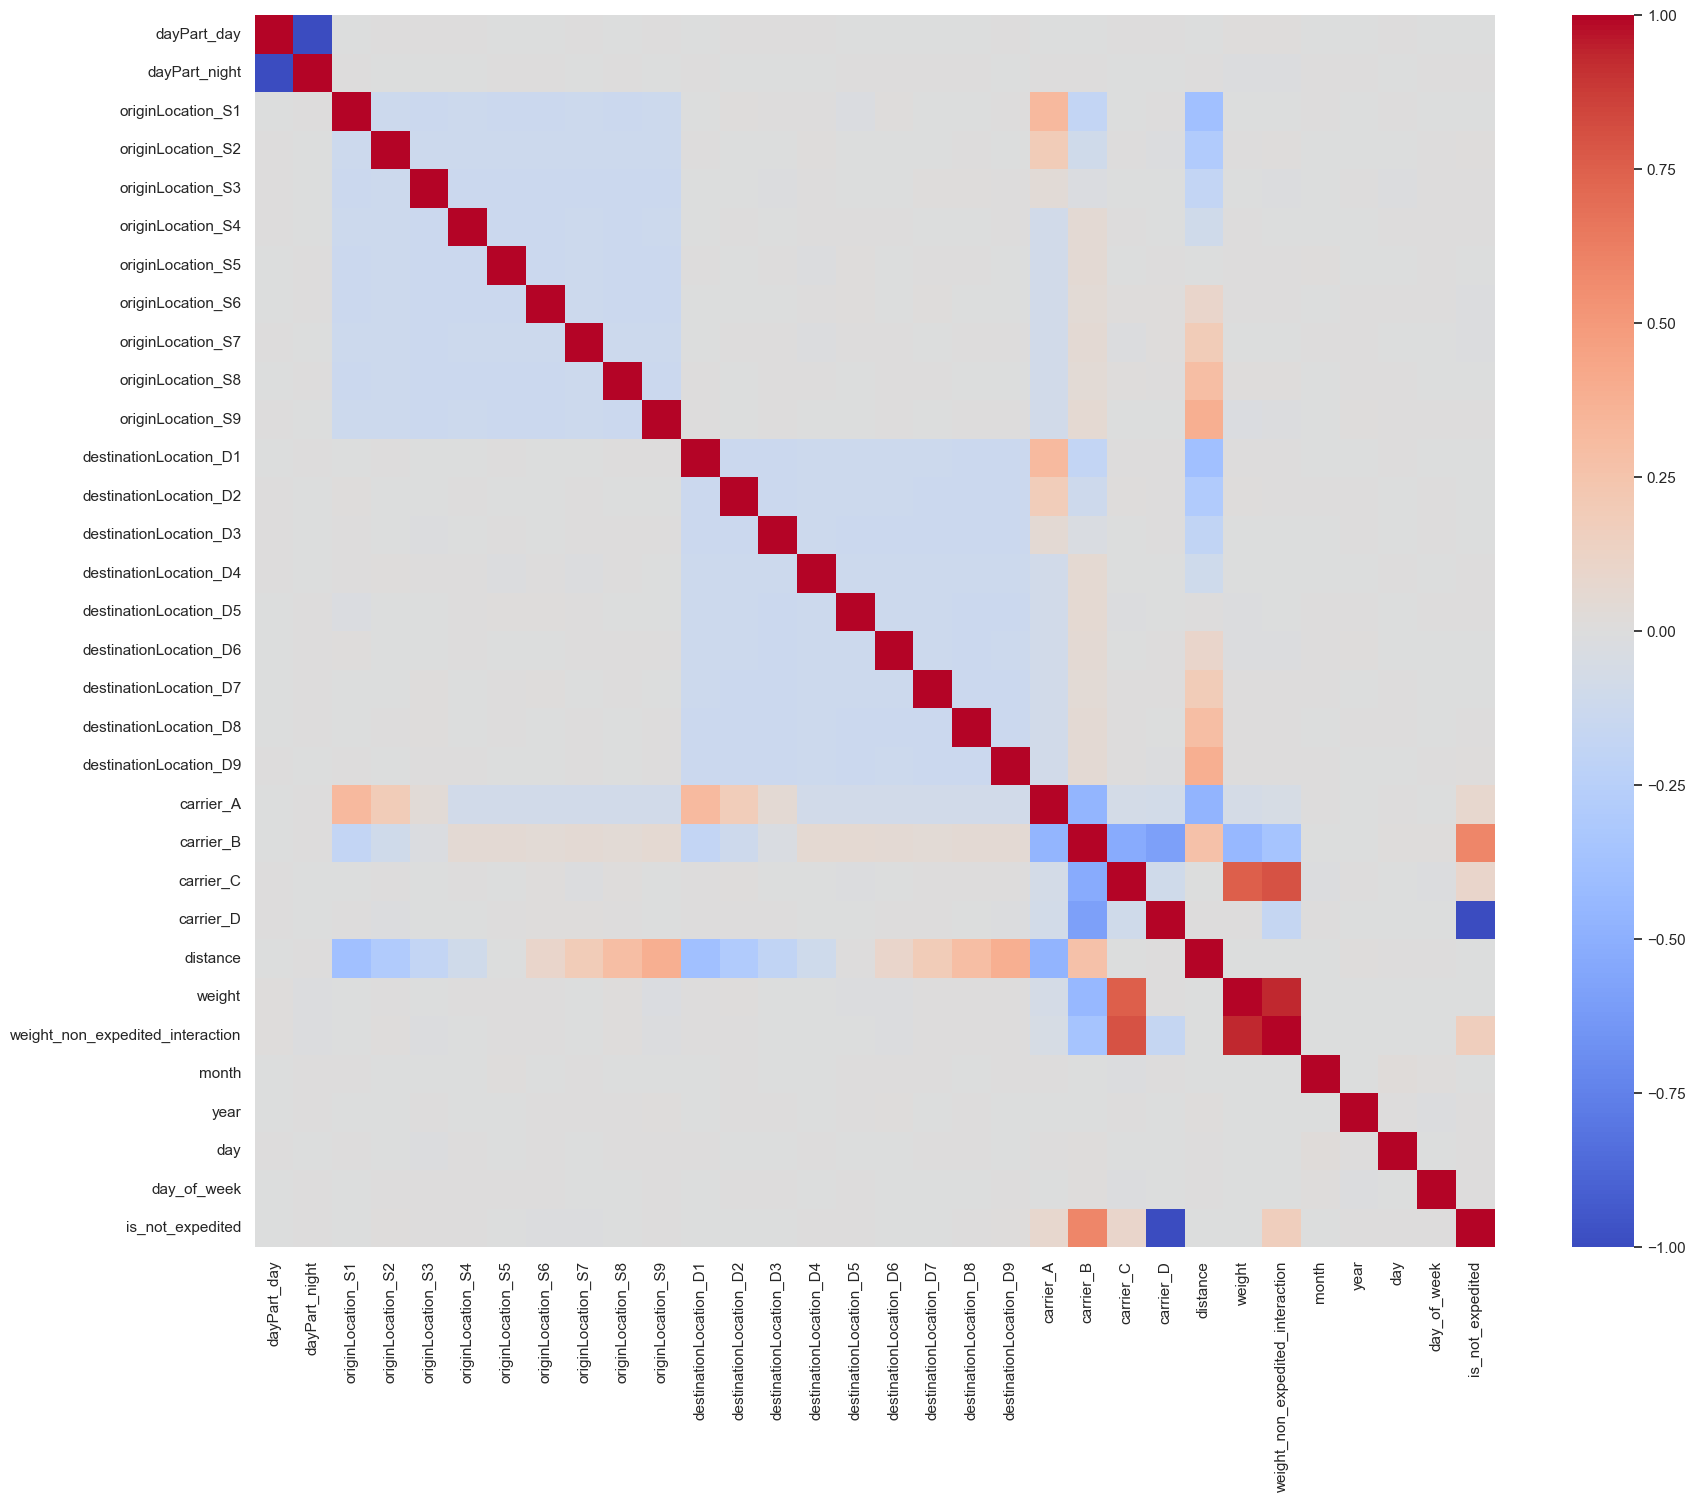

In [54]:
# Plot a heatmap to visualize the correlation between all variables
plt.figure(figsize = (20,16))
sns.heatmap(check_data.corr(), annot = False, cmap = 'coolwarm')

__Observations on the Heatmap:__
- __dayPart_day__ and __dayPart_night__ are strongly negative correlated.
- All one-hot encoding variables generated from __originLocation__ values are somewhat negative correlated.
- All one-hot encoding variables generated from __destinationLocation__ values are somewhat negative correlated.
- __distance__ is correlated to most one-hot encoding generated variables (for origin and destination)
- __carrier_A, carrier_B__ are also correlated to most one-hot encoding generated variables (for origin and destination) but in lesser values.
- __weight__ is related to carrier_C and carrier_D, as well as weight_non_expedited_interaction
- __Most importantly, most relationship between our variables show no correlation between themselves, which is desired for machine learning models.__

## 14. Feature Selection

As we can not use all these variables to train a machine learning model,

we need to perform __feature selection__ to select only the best variables that define cost prediction of deliveries.

__First, we specify the Lasso Regression model, and we select a suitable alpha (equivalent of penalty).__

__The bigger the alpha the less features that will be selected.__

__Then we use the selectFromModel object from sklearn, which will select automatically the features which coefficients are non-zero.__

In [55]:
# remember to set the seed, the random state in this function
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=42))

# train Lasso model and select features
sel_.fit(check_data, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=42))

In [56]:
# let's print the number of total and selected features by first making a list of these
selected_feats = check_data.columns[(sel_.get_support())]

# let's print some stats
print('total features: {}'.format((check_data.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))

total features: 32
selected features: 12
features with coefficients shrank to zero: 20


In [57]:
selected_feats

Index(['dayPart_day', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D',
       'distance', 'weight', 'weight_non_expedited_interaction', 'year', 'day',
       'day_of_week', 'is_not_expedited'],
      dtype='object')

We have identified the selected features for our machine learning models.

__With features selection we just discarded 3 columns.__

We can proceed to build our models.

### 15. Modeling

We will measure our model performance using __MSE, RMSE, and R2.__

To calculate these metrics let's __define a function__ that, given a model/estimator

it __makes predictions and then calculates and displays these metrics as a result.__

Let's not forget to apply the __exponential__ function to our prediction (using Numpy.exp), as we initially applied a log on our target.

In [58]:
# define a function to print the metrics MSE, RMSE and R2 from a given estimator (parameter)
def regression_metrics(estimator, X_train, X_test, y_train, y_test):
    # first, make predictions from our training subset
    pred = estimator.predict(X_train)
    # display metrics from our training subset
    print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
    print('train rmse: {}'.format(int(
        mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
    print('train r2: {}'.format(
        r2_score(np.exp(y_train), np.exp(pred))))
    print()

    # make predictions for test set
    pred = estimator.predict(X_test)
    # display metrics for test subset
    print('test mse: {}'.format(int(
        mean_squared_error(np.exp(y_test), np.exp(pred)))))
    print('test rmse: {}'.format(int(
        mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
    print('test r2: {}'.format(
        r2_score(np.exp(y_test), np.exp(pred))))
    print()
    # calculate the average cost of deliveries
    print('Average cost: ', int(np.exp(y_train).median()))


Lets use our final built pipeline to get our __transformed test and train subsets__.

As we are doing this for both our subsets, let's define a function to avoid repeating code.

In [59]:
# define a function to transform a subset using our final built pipeline
def transform_subset(final_pipeline, X_subset):
    # apply our final pipeline to our training subset
    transformed_data_X_subset = final_pipeline.fit_transform(X_subset)
    transformed_data_X_subset = pd.DataFrame(transformed_data_X_subset,columns = all_feature_names)
    X_subset_T = transformed_data_X_subset[selected_feats] # our transformed training subset
    return X_subset_T

In [60]:
# apply our final pipeline to our training subset
X_train_T = transform_subset(final_pipeline, X_train)

# apply our final pipeline to our testing subset
X_test_T = transform_subset(final_pipeline, X_test)

In [61]:
X_train_T.shape

(35099, 12)

In [62]:
X_test_T.shape


(3900, 12)

So, for our final transformed train subset we have __35'099 rows and 12 features__,

and for our final transformed test subset we have __3'900 rows and 12 features.__

## 15.1 Linear Regressor
Let's use a __Linear Regressor model to predict the cost__ of deliveries.

We will __use a Cross Validation method with 5 folds and select the best model out of the 5.__

In [63]:
# instantiate a Linear Regression object
linear = LinearRegression()

# define a scoring method for our cross validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# apply cross validation with 5 folds (80-20)
cv_results = cross_validate(linear, X_train_T, y_train, cv=5, scoring=mse_scorer, return_estimator=True)

In [64]:
# let's see the results of our cross validation
cv_results

{'fit_time': array([0.02413607, 0.01938033, 0.03126407, 0.03137231, 0.01999402]),
 'score_time': array([0.00262451, 0.        , 0.        , 0.        , 0.00378513]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_score': array([-0.10488008, -0.10046906, -0.1067177 , -0.11087009, -0.10341382])}

The result show us __5 models, with 5 scores and their corresponding fit times.__

Now, we will __choose only the best one (highest test_score).__

In [65]:
# choose the best model
trained_models = cv_results['estimator'] # save all cross validation models
best_model_linear_index = np.argmin(cv_results['test_score']) # get the best model index
best_model_linear = trained_models[best_model_linear_index] # get the best model from our CV
# calculate MSE, RMSE, and R2 metrics from the best model using our defined function for metrics
regression_metrics(
    estimator=best_model_linear,
    X_train=X_train_T,
    X_test=X_test_T,
    y_train=y_train,
    y_test=y_test
)

train mse: 5175
train rmse: 71
train r2: 0.8401890620402753

test mse: 2633
test rmse: 51
test r2: 0.9250107898076436

Average cost:  46


Text(0.5, 1.0, 'Evaluation of Linear Predictions')

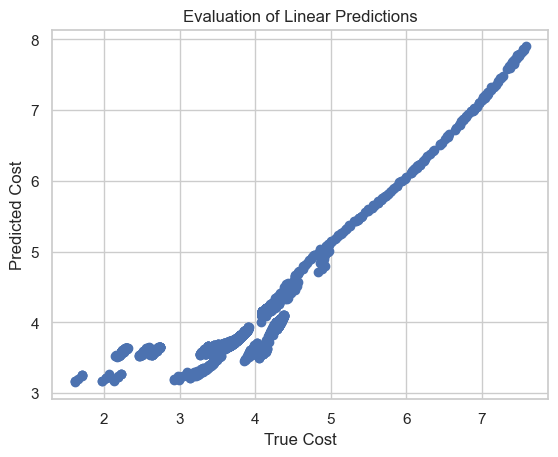

In [66]:
# using our best model let's evaluate our predictions respect to the real cost of deliveries
plt.scatter(y_test, best_model_linear.predict(X_test_T))
plt.xlabel('True Cost')
plt.ylabel('Predicted Cost')
plt.title('Evaluation of Linear Predictions')

__Observations:__
- As reference, a perfect prediction should show an y=x line
- As we can visualize, our predictions are somewhat similar to the y=x line, but only for costs above 5.
- For costs below 5, the Linear Regressor model has trouble predicting true cost.

## 15.2 Random Forest Regressor

Now, let's use a __Random Foret Regressor to predict cost of deliveries.__

In [67]:
# instantiate our RandomForest model
random_forest = RandomForestRegressor(n_estimators = 100,random_state=42)
random_forest.fit(X_train_T, y_train) # fit our model

RandomForestRegressor(random_state=42)

In [68]:
# print our metrics for this Random Foret model
regression_metrics(estimator=random_forest,
                   X_train=X_train_T,
                   X_test=X_test_T,
                   y_train=y_train,
                   y_test=y_test)

train mse: 0
train rmse: 0
train r2: 0.9999958751324726

test mse: 225
test rmse: 15
test r2: 0.9935930426993773

Average cost:  46


## 15.3 Multiple Models

Lets try using multiple models to compare their performance easily.

We will try predicting cost of deliveries with the following models:
- XGBoost
- SVR
- Decisision Tree
- Random Forest (once again)

In [69]:
# import required libraries for our multiple model training
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import FunctionTransformer

# Assuming you have a 'preproc' pipeline defined before this point
# Also, assuming you have X_train, X_test, y_train, and y_test defined before this point
# Define our models to use
Model = [
    XGBRegressor(objective='reg:squarederror', n_estimators=1000),
    SVR(kernel="rbf", C=0.025),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=100, random_state=42),
]
# let's loop through every model
for clf in Model:
    # let's first perform our model through our pipeline
    estimator = Pipeline([
        ('preproc', preproc), # our pre defined preprocessor pipeline
        ('to_dataframe', FunctionTransformer(lambda x: pd.DataFrame(x, columns=all_feature_names), validate=False)), # set the column names again
        ('selector', DataFrameSelector(selected_feats)), # use only selected features by Lasso
        ('model', clf) # apply the selected model
    ])
    estimator.fit(X_train, y_train) # fit our model
    name = clf.__class__.__name__ # save our model name
    
    # print the model metrics: MSE, RMSE, R2
    print(f'\033[94m-'*30, '\n')
    print(name)
    regression_metrics(
        estimator=estimator,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    )

print(f'\033[94m-'*30)


------------------------------ 

XGBRegressor
train mse: 3
train rmse: 1
train r2: 0.999894325996334

test mse: 143
test rmse: 11
test r2: 0.9959018966718748

Average cost:  46
------------------------------ 

SVR
train mse: 3781
train rmse: 61
train r2: 0.8832326504989861

test mse: 4282
test rmse: 65
test r2: 0.8780619958336398

Average cost:  46
------------------------------ 

DecisionTreeRegressor
train mse: 0
train rmse: 0
train r2: 1.0

test mse: 1
test rmse: 1
test r2: 0.9999475170288689

Average cost:  46
------------------------------ 

RandomForestRegressor
train mse: 0
train rmse: 0
train r2: 0.9999958751324726

test mse: 1
test rmse: 1
test r2: 0.9999649855083268

Average cost:  46
------------------------------


## 15.4 Elastic Net

Having tried multiple models, we can also __apply Elastic Net to predict our cost of deliveries.__

This time, we will __find the best parameters for the ElasticNet__ model as well.

To find the best parameters we will __use RandomizedSearchCV__, previously defining our hyper-parameters.

In [70]:
# define the hyper-parameters for randomized sesarch CV
param_grid = [{'alpha': [0.005,0.04,0.2,1,20,400,10000],
               'l1_ratio' : [1, 2.5, 3, 3.5, 4]}]
# define a new pipeline to apply Elastic Net
estimator = Pipeline([
    ('preproc', preproc), # we transform our subsets applying scaling, and one-hot encoding
    ('to_dataframe', FunctionTransformer(lambda x: pd.DataFrame(x, columns=all_feature_names), validate=False)), # set the column names again
    ('selector', DataFrameSelector(selected_feats)), # use only selected features by Lasso
    ('model', ElasticNet()) # apply ElasticNet model
])

# Find the best parameters for ElasticNet
randomized_search_elastic_net = RandomizedSearchCV(estimator, param_grid, n_iter=10, cv=10, scoring='neg_mean_squared_error')
estimator.fit(X_train, y_train) # fit the model

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('selector',
                                                                   DataFrameSelector(attribute_names=['dayPart',
                                                                                                      'originLocation',
                                                                                                      'destinationLocation',
                                                                                                      'carrier'])),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier']),
                                                 ('num_pipeline',
                                                  Pipeline(s...
                                                   'day_of_week'])])),
                ('to_dataframe',
                 FunctionTransformer(func=<function <lambda> at 0x000001F0E0B84EA0>)),
                ('selector',
                 DataFrameSelector(attribute_names=Index(['dayPart_day', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D',
       'distance', 'weight', 'weight_non_expedited_interaction', 'year', 'day',
       'day_of_week', 'is_not_expedited'],
      dtype='object'))),
                ('model', ElasticNet())])

In [71]:
# print metrics of our ElasticNet model
regression_metrics(estimator=estimator,
                   X_train=X_train,
                   X_test=X_test,
                   y_train=y_train,
                   y_test=y_test)

train mse: 31953
train rmse: 178
train r2: 0.013253977947375373

test mse: 34712
test rmse: 186
test r2: 0.011594539815474536

Average cost:  46


Text(0.5, 1.0, 'Evaluation of Elactic Net Predictions')

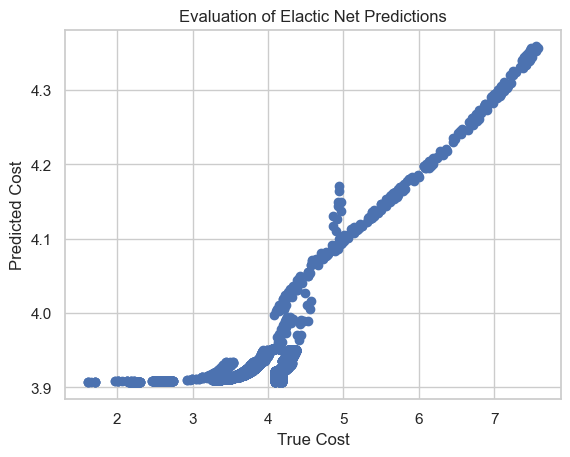

In [72]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, estimator.predict(X_test))
plt.xlabel('True Cost')
plt.ylabel('Predicted Cost')
plt.title('Evaluation of Elactic Net Predictions')

__Observations:__
- The predicted cost for ElasticNet vs true cost seem to __follow a linear relation for values above 4__
- However, __some data points are spread, meaning they are adding MSE__, because they were not predicted accurately.
- If we see the axis scales we will realize that __most predicted costs lie between 3.9 and 4.4, while true costs lie between 1 and 8.__

## 16. TensorFlow

As next step, we will use __Tensorflow to build a Sequential model and define layers.__

Then, let's use this model to __predict cost of deliveries and compare results__ with previous models using defined metrics.

Let's go ahead and build our model.

In [73]:
# import required libraries for tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# define a function for building the Sequential model
def build_model():
    # let's set up the layers
    model = models.Sequential([
        layers.Dense(64,activation = 'relu',input_shape = (X_train_T.shape[1],)),
        layers.Dense(64,activation = 'relu'),
        layers.Dense(1)
    ])
    # set up the optimizer as adam
    optimizer = 'adam'
    # compile the model using an MSE metric as loss
    model.compile(loss = 'mse',
                  optimizer = optimizer,
                  metrics =['mae','mse']
                 )
    return model

# build the model and print the summary
seq_model = build_model()
seq_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5057 (19.75 KB)
Trainable params: 5057 (19.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
# define a class to visualize the training process
class PrintDot(callbacks.Callback):
    # Visualize the training process, each line is 1 epoch
    def on_epoch_end(self,epoch,logs):
        if epoch%100 == 0: print('')
        print('-',end='')
EPOCHS = 1000 # let's set 1000 epochs

# train the sequential model, this make take more than 15min
history = seq_model.fit(
    X_train_T,y_train,
    epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks = [PrintDot()]
)




----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

Now that we have trained our model, let's make some interesting plots

to __visualize our training process__ and __how the metrics (MAE and MSE) were reduced over time (over epochs).__

First, let's __save our training history into a pandas dataframe.__

In [75]:
# define a function to plot epoch vs MAE and epoch vs MSE to visualize our training process
def plot_epoch_vs_MAE_MSE(history):
    # save our training history into a Pandas dataframe
    hist = pd.DataFrame(history.history)

    # set the epoch column
    hist['epoch'] = history.epoch

    # visualize our training history dataset
    display(hist.tail())
    
    # Plot the MAE vs Epochs
    plt.figure()
    plt.title('Epoch vs Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.plot(hist['epoch'], hist['mae'], label = 'Train Error')
    plt.plot(hist['epoch'],hist['val_mae'], label = 'Val Error')
    plt.legend()
    plt.show()

    # Plot the MSE vs Epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(hist['epoch'], hist['mse'], label = 'Train Error')
    plt.plot(hist['epoch'],hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.show()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.000015,0.002291,0.000015,0.000020,0.001971,0.000020,995
996,0.000035,0.003251,0.000035,0.000031,0.003238,0.000031,996
997,0.000022,0.002901,0.000022,0.000028,0.003069,0.000028,997
998,0.000268,0.006051,0.000268,0.000034,0.001850,0.000034,998
999,0.000013,0.001991,0.000013,0.000030,0.001920,0.000030,999


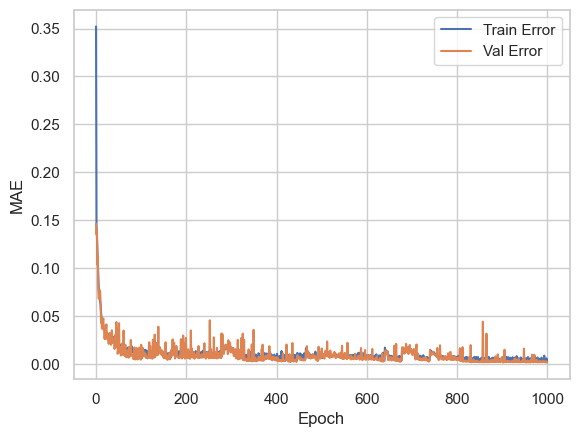

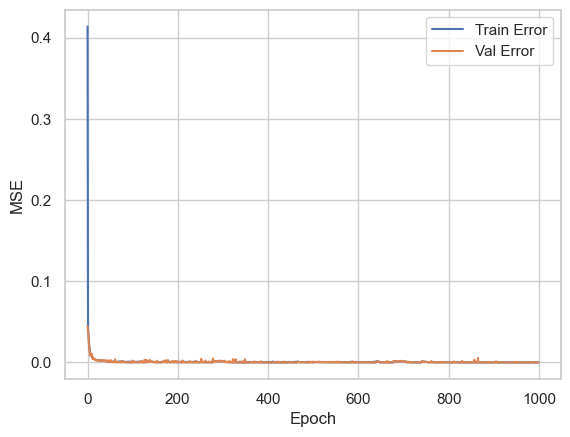

In [76]:
plot_epoch_vs_MAE_MSE(history)

__Observations:__
- __After epoch 100 there is no much reduction on the MSE.__
- On the other hand, __MAE continue to decrease significantly until epoch 600.__
- We can __succesfully predict cost of delivery__ values using our built model with at least 100 epochs.

Now, let's try to stop our training on any epoch, so we don't have to train 1000 epochs to get our results.

In [77]:
# set the Early Stopping
model = build_model()
early_stop= callbacks.EarlyStopping(monitor = 'val_loss',patience =10)
# we set a patience of 10 epochs so if our MSE doesn't improve in 10 epochs it will automatically stop

# once again, train the model, however, this time with the early stopping feature
history = model.fit(
    X_train_T,y_train,
    epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks = [early_stop,PrintDot()])


-------------------------------------------------------

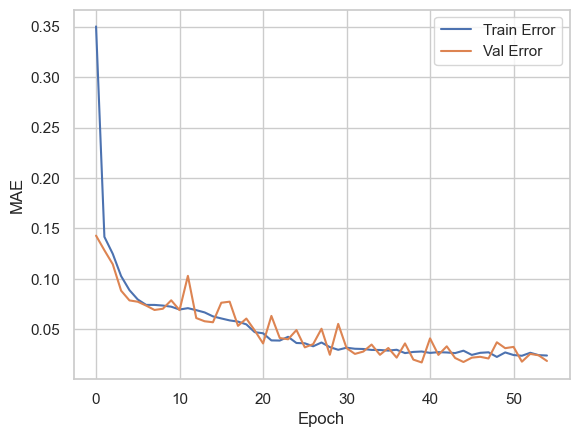

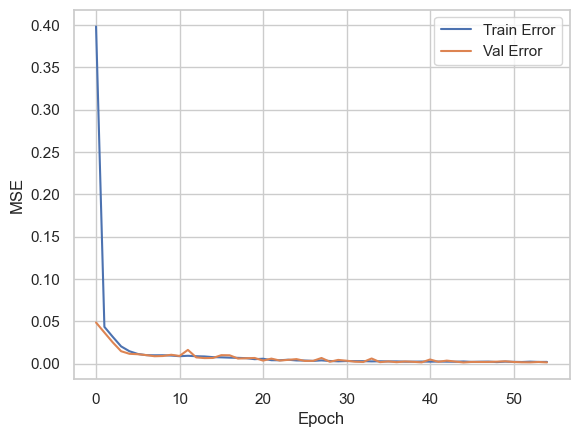

In [79]:
plot_epoch_vs_MAE_MSE(history)

__Observations:__
- Our training process lasted less than 100 epochs, meaning that our __MSE didn't change for 10 epochs before reaching 100.__
- We can __visualize how MSE and MAE were minimized over time__, specially MSE as it is an squared formula and we are using values lower than 1.
- These plots __show the training of our Sequential model to successfully predict cost of deliveries.__

Let's also print these metrics including the loss using the evaluate method.

In [80]:
# print loss, mae, and mse of our model
loss, mae,mse = model.evaluate(X_test_T, y_test)
print(f'Loss: {loss}, MAE: {mae}, MSE: {mse}')

122/122 [==============================] - 0s 2ms/step - loss: 0.0033 - mae: 0.0288 - mse: 0.0033
Loss: 0.003347967518493533, MAE: 0.028804844245314598, MSE: 0.003347967518493533


## 17. Best Model: RandomForestRegressor and parameter tuning

From all our tested models, the best one was __RandomForestRegressor__.

Now that we have the best __suitable model for this regression problem__, __let's find the best parameters for our Random Forest.__

We will find the best parameters __using GridSearchCV.__

First, we need to __define the hyper-parameters.__


### Hyper Parameter Tuning

In [81]:
# define hyper parameters of random forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# instantiate the model
random_forest = RandomForestRegressor()

# use Grid Search Cross Validation to find the best parameters for our Random Forest, using 5 folds
grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train_T, y_train) # fit our grid search

# Print the best parameters and corresponding mean squared error
print("Best Parameters: ", grid_search.best_params_)
print("Best Negative Mean Squared Error: ", grid_search.best_score_)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Negative Mean Squared Error:  -7.689803583633741e-06


Now that we have found the __best parameters for our Random Forest model__.

Let's, once again, __predict the cost of deliveries, but this time using the best possible parameters, and our previously engineered pipeline.__

In [82]:
# instantiate the Random Forest using the best parameters found with Grid Search
random_forest = RandomForestRegressor(**grid_search.best_params_)
# process our data through our defined pipeline, apply scaling, encoding, transformations, and model
estimator_random_forest_best = Pipeline([
    ('preproc', preproc),
    ('to_dataframe', FunctionTransformer(lambda x: pd.DataFrame(x, columns=all_feature_names), validate=False)),
    ('selector', DataFrameSelector(selected_feats)),
    ('model', random_forest)
])
# fit our model
estimator_random_forest_best.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('selector',
                                                                   DataFrameSelector(attribute_names=['dayPart',
                                                                                                      'originLocation',
                                                                                                      'destinationLocation',
                                                                                                      'carrier'])),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier']),
                                                 ('num_pipeline',
                                                  Pipeline(s...
                ('to_dataframe',
                 FunctionTransformer(func=<function <lambda> at 0x000001F0D6481080>)),
                ('selector',
                 DataFrameSelector(attribute_names=Index(['dayPart_day', 'carrier_A', 'carrier_B', 'carrier_C', 'carrier_D',
       'distance', 'weight', 'weight_non_expedited_interaction', 'year', 'day',
       'day_of_week', 'is_not_expedited'],
      dtype='object'))),
                ('model', RandomForestRegressor())])

In [83]:
# print the metrics of our new best parameters Random Forest
regression_metrics(estimator=estimator_random_forest_best,
                   X_train=X_train,
                   X_test=X_test,
                   y_train=y_train,
                   y_test=y_test)

train mse: 0
train rmse: 0
train r2: 0.9999958970242216

test mse: 1
test rmse: 1
test r2: 0.9999636468030314

Average cost:  46


## 18. Predict New Test Data¶

Now that we have our __final tuned model__, we can __test it using new test data.__

Let's __read this data from a csv file, apply some transformations__ that are required:
- drop trip column (as they are just IDs)
- apply our previously engineered pipeline using our defined class
- predict values using our best-parameters Random Forest

Finally, we will __save our predictions on a CSV file for later submission.__

In [84]:
# load the unseen / new dataset (testing data)
unseen_data = pd.read_csv('test.csv')

# rows and columns of the data
print(unseen_data.shape)

# visualise the dataset
unseen_data.head()

(802, 11)


,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier
0,t333282728025,2017-09-27,night,NaN,S2,D8,2000,NaN,50,NaN,C
1,t35583500660,2017-12-12,day,snow,S2,D1,600,NaN,22,NaN,A
2,t117664376784,2018-11-18,day,NaN,S7,D1,1600,expedited,30,NaN,D
3,t261320757828,2019-11-18,day,NaN,S5,D6,2200,NaN,32,NaN,B
4,t147086054909,2019-06-02,night,heat,S6,D7,2600,NaN,7,NaN,B


In [85]:
# let's drop the id's as they are not required for our analysis (see first steps)
unseen_data.drop('trip', axis=1, inplace=True)

In [86]:
# transform our data adding the new engineered features
data_custom_transformed = customTransformer().transform(unseen_data)

In [87]:
# predict the values of our new test data using our best-parameters-random-forest
pred = estimator_random_forest_best.predict(data_custom_transformed)

In [88]:
# add these new predictions to a pandas dataframe (only predicted cost)
# don't forget to apply Numpy.exp as we previously applied the log function to our target
pred = pd.DataFrame(np.exp(pred),columns=['cost'])
Id_test = pd.read_csv('test.csv')

# reincorporate the delivery ID (trip column) and save the results to a CSV file for submission
Id_test = Id_test['trip']
result = pd.concat([Id_test, pred], axis=1)
result.to_csv('final_sub.csv', index=False)

In [89]:
# display results
result

,trip,cost
0,t333282728025,57.320087
1,t35583500660,29.205727
2,t117664376784,63.000000
3,t261320757828,72.879815
4,t147086054909,34.905738
...,...,...
797,t353400176448,1709.313132
798,t112945848426,38.380903
799,t53097944970,35.631378
800,t127986960246,66.000000
